In [1]:
import random
random.seed(19585781)

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('musicData.csv')


df.replace('?', np.nan, inplace=True)


df.dropna(subset=['track_name', 'artist_name'], inplace=True)

categorical = ['key', 'mode']
numerical = ['popularity', 'acousticness', 'danceability', 'duration_ms', 
                      'energy', 'instrumentalness', 'liveness', 'loudness', 
                      'speechiness', 'tempo', 'valence']


for col in numerical:
    df[col] = pd.to_numeric(df[col], errors='coerce')


for col in numerical:
    if df[col].dtype == 'object':
        # Identify non-numeric entries
        non_numeric_entries = df[df[col].apply(lambda x: not x.isnumeric())]
        if not non_numeric_entries.empty:
            print(f"Non-numeric entries found in {col}:")
            print(non_numeric_entries[col])


imputer = SimpleImputer(strategy='median')
df[numerical] = imputer.fit_transform(df[numerical])


print("Data types after conversion and imputation:")
print(df[numerical].dtypes)



scaler = StandardScaler()
df[numerical] = scaler.fit_transform(df[numerical])


key_dummies = pd.get_dummies(df['key'], prefix='key')
df = pd.concat([df, key_dummies], axis=1)
df.drop('key', axis=1, inplace=True)

# Applying dummy coding to 'mode'
mode_dummies = pd.get_dummies(df['mode'], prefix='mode')
df = pd.concat([df, mode_dummies], axis=1)
df.drop('mode', axis=1, inplace=True)


le = LabelEncoder()
df['music_genre'] = le.fit_transform(df['music_genre'])


genre_labels = dict(zip(le.classes_, le.transform(le.classes_)))
print("Genre to label mapping:", genre_labels)

for col in df.columns:
    if df[col].dtype == 'object':
       
        df.drop(col, axis=1, inplace=True)



Data types after conversion and imputation:
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
dtype: object
Genre to label mapping: {'Alternative': 0, 'Anime': 1, 'Blues': 2, 'Classical': 3, 'Country': 4, 'Electronic': 5, 'Hip-Hop': 6, 'Jazz': 7, 'Rap': 8, 'Rock': 9}


Accuracy: 0.5798
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.37      0.40       500
           1       0.81      0.81      0.81       500
           2       0.66      0.58      0.62       500
           3       0.86      0.88      0.87       500
           4       0.61      0.58      0.60       500
           5       0.70      0.62      0.66       500
           6       0.38      0.39      0.38       500
           7       0.57      0.54      0.56       500
           8       0.33      0.35      0.34       500
           9       0.49      0.67      0.56       500

    accuracy                           0.58      5000
   macro avg       0.58      0.58      0.58      5000
weighted avg       0.58      0.58      0.58      5000

Genre 0 AUC Score: 0.86
Genre 1 AUC Score: 0.98
Genre 2 AUC Score: 0.93
Genre 3 AUC Score: 0.98
Genre 4 AUC Score: 0.93
Genre 5 AUC Score: 0.93
Genre 6 AUC Score: 0.92
Genre 7 AUC Score: 0.93
Genre 8 

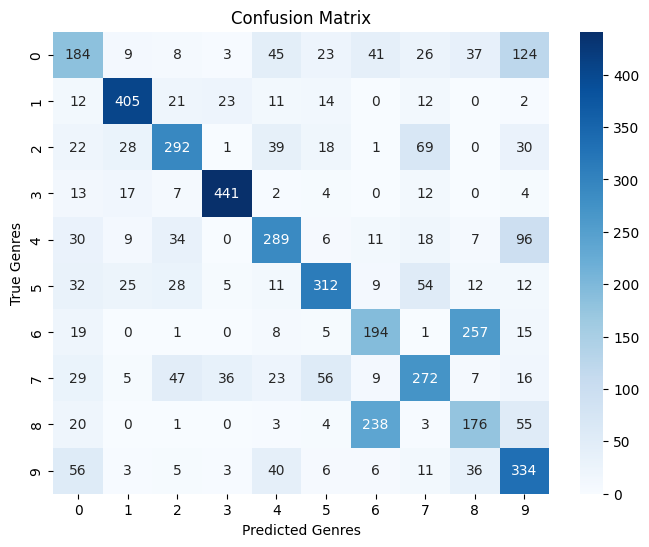

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# DataFrame preparation assumed
feature_types = [col for col in df.columns if 'key_' in col or 'mode_' in col]
numeric_features = df.columns.difference(feature_types + ['music_genre']).tolist()


numeric_transform = Pipeline(steps=[
    ('median_imputer', SimpleImputer(strategy='median')),
    ('standard_scaler', StandardScaler())
])

categorical_transform = Pipeline(steps=[
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))
])


data_preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transform, numeric_features),
        ('categorical', categorical_transform, feature_types)
    ])

# Define the full modeling pipeline
model_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('xgb_classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

train_indices_list = []
test_indices_list = []
genre_field = 'music_genre'


for genre, group_data in df.groupby(genre_field):
    train_group, test_group = train_test_split(group_data, test_size=500, random_state=42)
    train_indices_list.extend(train_group.index)
    test_indices_list.extend(test_group.index)

# Selecting data based on indices
training_data = df.loc[train_indices_list]
testing_data = df.loc[test_indices_list]


features_training = training_data.drop(['music_genre'], axis=1)
target_training = training_data['music_genre']
features_testing = testing_data.drop(['music_genre'], axis=1)
target_testing = testing_data['music_genre']


X_features = df.drop('music_genre', axis=1)
y_target = df['music_genre']


genre_encoder = LabelEncoder()
encoded_target = genre_encoder.fit_transform(df['music_genre'])

model_pipeline.fit(features_training, target_training)
predicted_labels = model_pipeline.predict(features_testing)

model_accuracy = accuracy_score(target_testing, predicted_labels)
print("Accuracy:", model_accuracy)

predicted_genres = genre_encoder.inverse_transform(predicted_labels)
true_genres = genre_encoder.inverse_transform(target_testing)
print("Classification Report:\n", classification_report(true_genres, predicted_genres))

music_classes = np.unique(target_training)  # Assuming target_training is your training label set
binary_labels = label_binarize(target_testing, classes=music_classes)
predicted_probs = model_pipeline.predict_proba(features_testing)

genre_specific_auc = {}

# Calculate AUC for each genre
for idx, music_genre in enumerate(music_classes):
    genre_specific_auc[music_genre] = roc_auc_score(binary_labels[:, idx], predicted_probs[:, idx])
    print(f"Genre {music_genre} AUC Score: {genre_specific_auc[music_genre]:.2f}")

print("\n")  

# Overall AUC score for all classes
total_auc = roc_auc_score(binary_labels, predicted_probs, multi_class='ovr')
print(f"Overall AUC: {total_auc:.2f}")

# Visualization of the confusion matrix
confusion_matrix_diagram = confusion_matrix(true_genres, predicted_genres, labels=genre_encoder.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_diagram, annot=True, fmt="d", cmap='Blues', xticklabels=genre_encoder.classes_, yticklabels=genre_encoder.classes_)
plt.xlabel('Predicted Genres')
plt.ylabel('True Genres')
plt.title('Confusion Matrix')
plt.show()


Genre to label mapping: {'Alternative': 0, 'Anime': 1, 'Blues': 2, 'Classical': 3, 'Country': 4, 'Electronic': 5, 'Hip-Hop': 6, 'Jazz': 7, 'Rap': 8, 'Rock': 9}


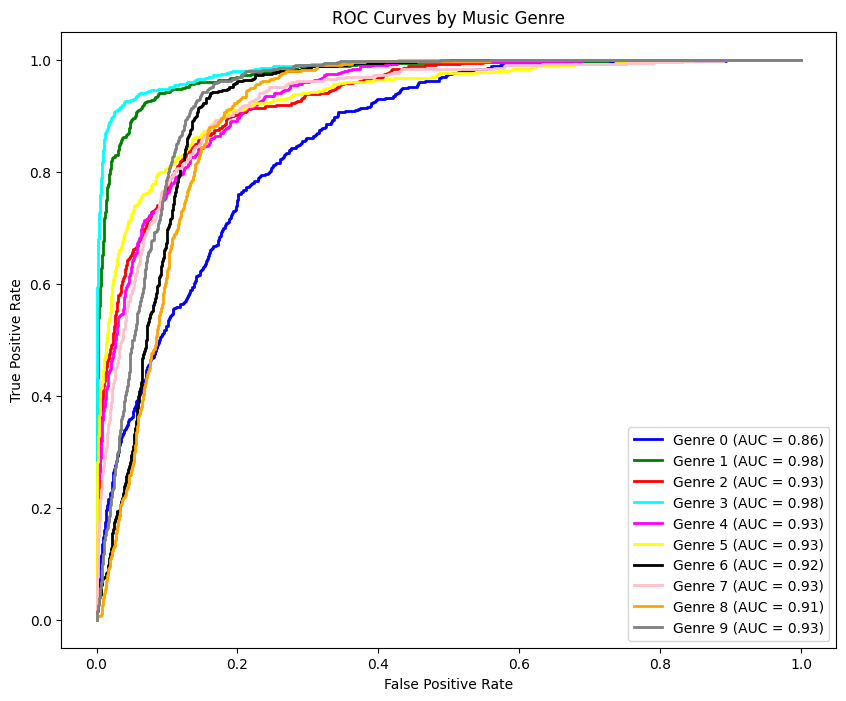

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

roc_points = {}
area_under_curve = {}

# Calculate ROC curve points and AUC for each class
for idx, genre in enumerate(music_classes):
    false_positive_rate, true_positive_rate, _ = roc_curve(binary_labels[:, idx], predicted_probs[:, idx])
    roc_points[idx] = (false_positive_rate, true_positive_rate)
    area_under_curve[idx] = auc(false_positive_rate, true_positive_rate)

print("Genre to label mapping:", genre_labels)

# Plotting the ROC curves for all classes
plt.figure(figsize=(10, 8))
color_palette = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'orange', 'grey']
for idx, color in zip(range(len(music_classes)), color_palette):
    plt.plot(roc_points[idx][0], roc_points[idx][1], color=color, lw=2,
             label='Genre {0} (AUC = {1:0.2f})'.format(music_classes[idx], area_under_curve[idx]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Music Genre')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import umap
import seaborn as sns
import matplotlib.pyplot as plt

# Load the music dataset
music_data = pd.read_csv('musicData.csv')

# Identify numerical columns in the dataset
numerical_cols = music_data.select_dtypes(include=['number']).columns

# Normalize the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(music_data[numerical_cols])

# Apply UMAP for dimensionality reduction
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
low_dim_embedding = umap_reducer.fit_transform(scaled_features)

# Encode genres to numerical labels
genre_encoder = LabelEncoder()
encoded_genres = genre_encoder.fit_transform(music_data['music_genre'])

# Plotting the UMAP reduced data
plt.figure(figsize=(12, 10))
genre_palette = sns.color_palette("hsv", len(set(encoded_genres)))
sns.scatterplot(
    x=low_dim_embedding[:, 0], 
    y=low_dim_embedding[:, 1], 
    hue=genre_encoder.inverse_transform(encoded_genres),
    palette=genre_palette
)
plt.title('UMAP Visualization of Music Genres')
plt.xlabel('First UMAP Dimension')
plt.ylabel('Second UMAP Dimension')
plt.legend(title='Music Genre')
plt.show()
